# Rotate vols and FSC

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual

import jax
import mrcfile
from jax.scipy.special import gammaln
from tqdm import tqdm

plt.rcParams["figure.figsize"]=6,6

### Load the volumes

#### From source

In [3]:
#file1 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset10k/vol1_84.mrc"
#file2 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results10k/relion_clean/rec_iter_176.mrc"
#file2 = "/gpfs/gibbs/pi/lederman/bt387/simulated_dataset10k/relion_noisy/InitialModel/job001/run_it300_class001.mrc"
#nx0 = 256
#pixel_size = 1.244531

#file1 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset20k/vol2_84.mrc"
#file2 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results20k/cryodrgn_clean/rec_iter_176.mrc"
#file2 = "/gpfs/gibbs/pi/lederman/bt387/simulated_dataset20k/cryodrgn_noisy/InitialModel/job001/run_it300_class001.mrc"
#nx0 = 320
#pixel_size = 1.31

#file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1v/rec_final_nx0.mrc"
#file2 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem2v/rec_final_nx0.mrc"
#nx0 = 320
#pixel_size = 1.31

#file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/InitialModel/particles1_corrected/run_it300_class001.mrc"
#file2 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/InitialModel/particles2_corected/run_it300_class001.mrc"
#nx0 = 320
#pixel_size = 1.31

#vol1 = mrcfile.open(file1).data
#vol2 = mrcfile.open(file2).data



#### From my folder

In [6]:
# Simulated relion data
#file1 = "/gpfs/gibbs/pi/lederman/bt387/pims_workshop_data/ground_truth/vol1_84.mrc"

#file2_root = "/gpfs/gibbs/pi/lederman/bt387/pims_workshop_data/sim_reconstruction_mcmc/relion_noisy"
#file2_root = "/gpfs/gibbs/pi/lederman/bt387/pims_workshop_data/sim_reconstruction_relion/relion_noisy"

#file2 = f"{file2_root}.mrc"
#nx0 = 256
#pixel_size = 1.244531


# Simulated cryodrgn data
#file1 = "/gpfs/gibbs/pi/lederman/bt387/pims_workshop_data/ground_truth/vol2_84.mrc"
#file2_root = "/gpfs/gibbs/pi/lederman/bt387/pims_workshop_data/sim_reconstruction_relion/cryodrgn_noisy"

#file2 = f"{file2_root}.mrc"
#nx0 = 320
#pixel_size = 1.31


# Experimental
#file1 = "/gpfs/gibbs/pi/lederman/bt387/pims_workshop_data/exp_reconstruction_relion/rec1.mrc"
file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1_switch_final/rec_final_nx0.mrc"

#file2_root = "/gpfs/gibbs/pi/lederman/bt387/pims_workshop_data/exp_reconstruction_relion/rec2"
#file2 = f"{file2_root}.mrc"|

#file2 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem2v/rec_final_nx0.mrc"
file2 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem2_switch_final/rec_final_nx0.mrc"


nx0 = 320
pixel_size = 1.31

In [7]:
vol1 = mrcfile.open(file1).data
vol2 = mrcfile.open(file2).data

In [8]:
vol1_f, _, _ = volume_fourier(vol1, pixel_size)
vol2_f, _, _ = volume_fourier(vol2, pixel_size)

In [9]:
print(f"vol1_f.shape = {vol1_f.shape}")
print(f"vol2_f.shape = {vol2_f.shape}")

vol1_f.shape = (320, 320, 320)
vol2_f.shape = (320, 320, 320)


In [10]:
nx = jnp.minimum(vol1_f.shape[0], vol2_f.shape[0])
grid1 = [1, vol1_f.shape[0]]
grid2 = [1, vol2_f.shape[0]]

In [11]:
nx = 84

In [12]:
vol1_f, _ = crop_fourier_volume(vol1_f, grid1, nx)
vol2_f, grid = crop_fourier_volume(vol2_f, grid2, nx)

In [13]:
print(f"vol1_f.shape = {vol1_f.shape}")
print(f"vol2_f.shape = {vol2_f.shape}")

vol1_f.shape = (84, 84, 84)
vol2_f.shape = (84, 84, 84)


In [14]:
#res, fsc, shell_points = calc_fsc(vol1_f, vol2_f, grid)
#res_angs = nx0 * pixel_size/res
#plt.semilogx(res_angs, fsc)

In [15]:
@jax.jit
def calc_corr(v1, v2):
    corr = jnp.sum(v1 * jnp.conj(v2)) / (jnp.linalg.norm(v1.ravel(),2) * jnp.linalg.norm(v2.ravel(),2))
    return jnp.real(corr)

@jax.jit
def rotate_and_calc_corr(v1, v2, angles0, angles_i):

    vol1_r = rotate_and_interpolate_full_object(v1, angles0, grid) 
    vol2_r = rotate_and_interpolate_full_object(v2, angles_i, grid) 
    
    return calc_corr(vol1_r, vol2_r)

rotate_and_calc_corr_vmap = jax.jit(jax.vmap(rotate_and_calc_corr, in_axes=(None, None, None, 0)))

#@jax.jit
def rotate_and_interpolate_full_object(vol, angles, grid):
    proj_coords = rotate_full_grid(grid, angles)
    return interpolate(proj_coords, grid, vol, "tri")


In [16]:
N = 50

a1_range = np.linspace(0, 2*jnp.pi, N)
a2_range = np.linspace(0, jnp.pi, N)
a3_range = np.linspace(0, 2*jnp.pi, N)

A1, A2, A3 = np.meshgrid(a1_range, a2_range, a3_range)  

angles = np.column_stack([A1.ravel(), A2.ravel(), A3.ravel()])
angles0 = np.array([0,0,0])

grid = np.array(grid)
vol1_f = jnp.array(vol1_f)
vol2_f = jnp.array(vol2_f)

In [17]:
# CHANGE CHIRALITY IF NEEDED!!

#vol2_f = jnp.flip(vol2_f, axis=1)

In [18]:
N_batch = 1000
angles_batch = np.array(np.array_split(angles, N_batch))

corrs_batch = []
for bi in tqdm(np.arange(N_batch)):
    corr_i = rotate_and_calc_corr_vmap(vol1_f, vol2_f, jnp.array(angles0), jnp.array(angles_batch[bi]))
    corrs_batch.append(corr_i)
    
corrs = np.concatenate(corrs_batch, axis=0)

100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


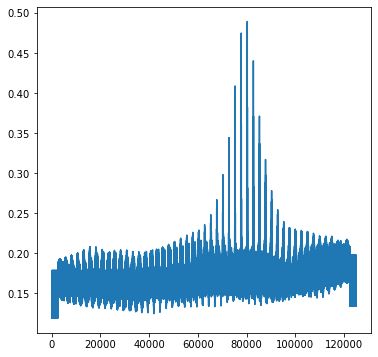

In [19]:
plt.plot(corrs)

In [20]:
vol2_f.shape

(84, 84, 84)

In [21]:
print(f"max corr = {jnp.max(corrs)}")
max_idx = jnp.argmax(corrs)
angles_good = angles[max_idx]

vol2_fr = rotate_and_interpolate_full_object(vol2_f, angles_good, grid)
vol2_fr = vol2_fr.reshape([nx,nx,nx])

max corr = 0.4893350005295573


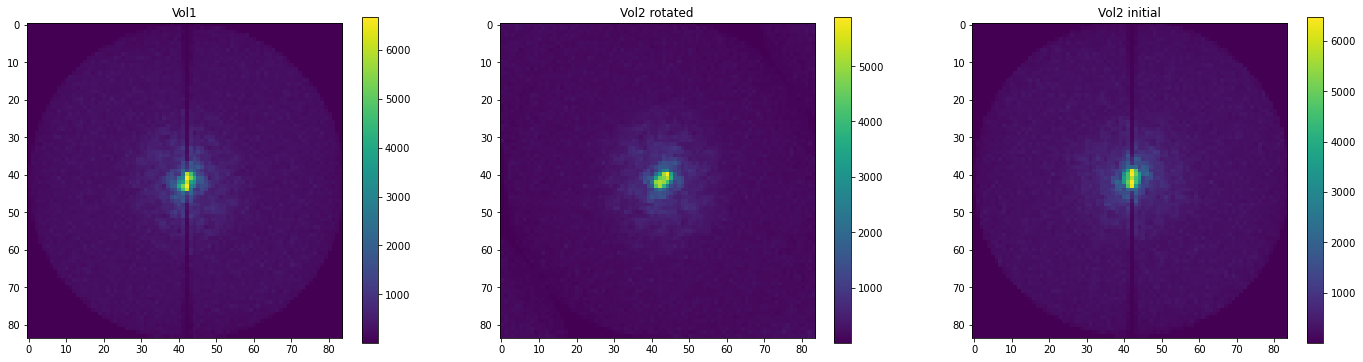

In [22]:
plt.rcParams["figure.figsize"]=24,6

plt.subplot(1,3,1)
mip_x(jnp.abs(jnp.fft.fftshift(vol1_f))); plt.colorbar()
plt.title("Vol1")

plt.subplot(1,3,2)
mip_x(jnp.abs(jnp.fft.fftshift(vol2_fr))); plt.colorbar()
plt.title("Vol2 rotated")


plt.subplot(1,3,3)
mip_x(jnp.abs(jnp.fft.fftshift(vol2_f))); plt.colorbar()
plt.title("Vol2 initial")

plt.rcParams["figure.figsize"]=6,6

In [23]:
res, fsc, shell_points = calc_fsc(vol1_f, vol2_fr, grid)

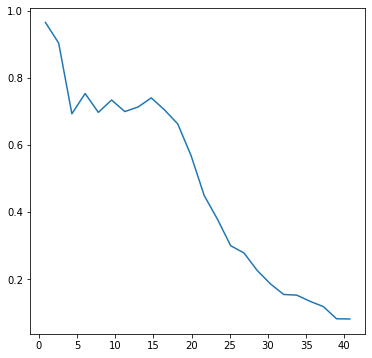

In [24]:
plt.plot(res, fsc)

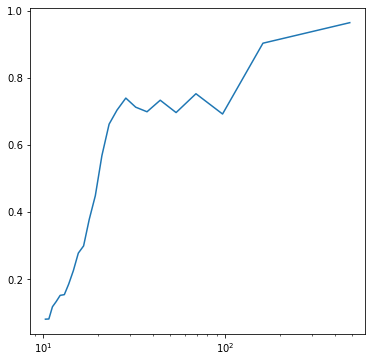

In [25]:
res_angs = nx0 * pixel_size/res
plt.semilogx(res_angs, fsc)

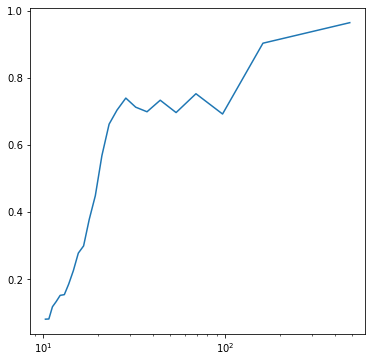

In [26]:
res_angs = nx0 * pixel_size/res
plt.semilogx(res_angs, fsc)

In [27]:
res_angs

DeviceArray([484.05046569, 161.35015523,  96.81009314,  69.15006653,
              53.78338508,  44.00458779,  37.23465121,  32.27003105,
              28.47355681,  25.4763403 ,  23.05002218,  21.04567242,
              19.36201863,  17.92779503,  16.69139537,  15.61453115,
              14.66819593,  13.83001331,  13.08244502,  12.4115504 ,
              11.80610892,  11.25698757,  10.75667702,  10.29894608],            dtype=float64)

In [28]:
fsc

DeviceArray([0.96444053, 0.90319563, 0.69209453, 0.75256206, 0.69641012,
             0.7332492 , 0.69882059, 0.71245112, 0.73957433, 0.70378477,
             0.66187756, 0.56822592, 0.4484868 , 0.37790349, 0.29886471,
             0.27734281, 0.22525964, 0.18528072, 0.15356138, 0.15143832,
             0.13301962, 0.11743099, 0.08102181, 0.08043531],            dtype=float64)

In [35]:
idx = 12
print(fsc[idx])
print(res_angs[idx])

0.4484867957300869
19.362018627543293


#### Save the FSC data to file

In [ ]:
file2_root

In [ ]:
file = open(f"{file2_root}_res_angs.pkl", 'wb')
pickle.dump(res_angs, file)
file.close()

file = open(f"{file2_root}_fsc.pkl", 'wb')
pickle.dump(fsc, file)
file.close()

In [ ]:
# Test the above:
with open(f"{file2_root}_res_angs.pkl", 'rb') as file:
    # Call load method to deserialze
    res_angs2 = pickle.load(file)
with open(f"{file2_root}_fsc.pkl", 'rb') as file:
    # Call load method to deserialze
    fsc2 = pickle.load(file)    

In [ ]:
assert jnp.sum(jnp.abs(fsc - fsc2)) == 0
assert jnp.sum(jnp.abs(res_angs - res_angs2)) == 0

#### Save the rotated vol - not great. flipping the ifftshifted fft is WRONG. plus errors from interpolation so the volume doesn't look good

In [ ]:
vol2_fr, _ = rescale_larger_grid(vol2_fr, grid, nx0)
vol2_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol2_fr)))
with mrcfile.new( f"{file2_root}_fixed.mrc", overwrite=True) as mrc:
    mrc.set_data(vol2_r.astype(np.float32))

### Orientation errors for the simulated data

In [ ]:
mk

In [ ]:
dataset = "cryodrgn_noisy"
outfile = "angles_plots/set2_noisy"

In [ ]:
# Correct angles
data_dir = f"/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset20k/{dataset}/"
star_file = "particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = False, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

In [ ]:
# My angles
myfilename = f"/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results20k/{dataset}/rec_iter_176_angles"
with open(myfilename, 'rb') as file:
    # Call load method to deserialze
    angles_rec = pickle.load(file)
    
angles_rec_mcmc = angles_rec[0]

In [ ]:
#Or relion's angles

relion_dir = f"/gpfs/gibbs/pi/lederman/bt387/simulated_dataset20k/{dataset}/InitialModel/job001/"
relion_star_rec = "run_it300_data.star"

params_relion, _ = load_data(relion_dir, relion_star_rec, load_imgs = False, fourier = False)
angles_rec_rel = params_relion["angles"]


In [ ]:
theta_mcmc, cord_distance_mcmc = err_orientations(angles0, angles_rec_mcmc)
theta_relion, cord_distance_relion = err_orientations(angles0, angles_rec_rel)


In [ ]:
#nbins=100
#counts, bins = np.histogram(theta_mcmc, bins=nbins)
#_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
#nbins=100
#counts, bins = np.histogram(theta_relion, bins=nbins)
#_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
outfile

In [ ]:
nbins = 100
counts, bins = np.histogram((cord_distance_mcmc - jnp.median(cord_distance_mcmc))**2, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig(f"{outfile}_hist_mcmc.png", dpi=600)
            

In [ ]:
nbins = 100
counts, bins = np.histogram((cord_distance_relion - jnp.median(cord_distance_relion))**2, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig(f"{outfile}_hist_relion.png", dpi=600)

In [ ]:
jnp.max(bins)

In [ ]:
print(f"{dataset},")
print(f"cord dist mcmc = {jnp.median((cord_distance_mcmc - jnp.median(cord_distance_mcmc))**2)},")
print(f"cord dist relion = {jnp.median((cord_distance_relion - jnp.median(cord_distance_relion))**2)}")

In [ ]:
plt.plot(jnp.sort((cord_distance_mcmc - jnp.median(cord_distance_mcmc))**2), color='r')
plt.plot(jnp.sort((cord_distance_relion - jnp.median(cord_distance_relion))**2), color='blue')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(["MCMC", "Relion"], fontsize=15)

plt.savefig(f"{outfile}_sorted_errs.png", dpi=600)


### Misc

In [ ]:
file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1v/rec_iter_150.mrc"
#file1 = "/gpfs/gibbs/pi/lederman/bt387/simulated_dataset10k/relion_clean/InitialModel/job001/run_it300_class001.mrc"

nx0 = 320
pixel_size = 1.31

vol1 = mrcfile.open(file1).data

vol1_f, _, _ = volume_fourier(vol1, pixel_size)

In [ ]:
grid = [1, vol1_f.shape[0]]
vol_fc, _ = rescale_larger_grid(vol1_f, grid, 320)
vol_rc = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc)))


In [ ]:
mip_x(vol_rc)

In [ ]:
vol_rc = jnp.flip(vol_rc, axis=0)

In [ ]:
#with mrcfile.new(f"/gpfs/gibbs/pi/lederman/bt387/exp_data/vol2_test10.mrc", overwrite=True) as mrc:
#    mrc.set_data(vol_rc.astype(np.float32))